In [1]:
using CSV, DataFrames
df = CSV.read("../data/race_dataset.csv", DataFrame)

Row,box,odds,slit_score,horse
,Int64,Float64,Float64,String31
1,2,4.7,1.0,ブラウンラチェット
2,1,15.6,0.498544,ミストレス
3,8,4.1,0.498544,ショウナンザナドゥ
4,4,6.6,0.353499,シホリーン
5,3,6.3,0.296296,マイエレメント
6,10,3.1,0.245623,カムニャック
7,6,57.9,0.125,マピュース
8,11,79.9,0.0251356,クレオズニードル
9,5,13.4,0.00201291,ミリオンローズ


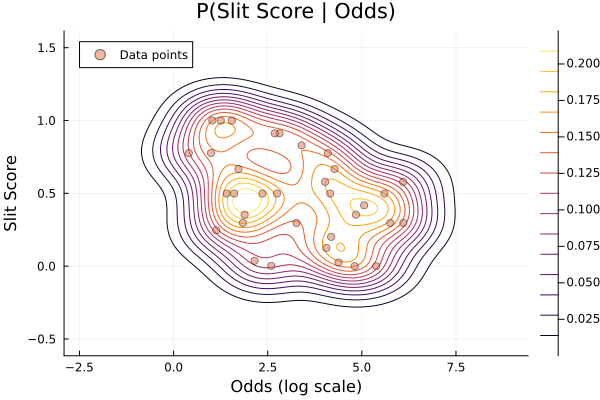

In [2]:
using KernelDensity, StatsPlots

# データの準備
odds = df.odds
slit_score = df.slit_score

# 2次元KDEの計算
kde_obj = kde((log.(odds), slit_score))  # オッズは対数スケールで扱う

# 条件付き確率密度関数の計算と可視化
p = plot(xlabel="Odds (log scale)", ylabel="Slit Score", title="P(Slit Score | Odds)")
contour!(p, kde_obj.x, kde_obj.y, kde_obj.density')
scatter!(p, log.(odds), slit_score, alpha=0.5, label="Data points")


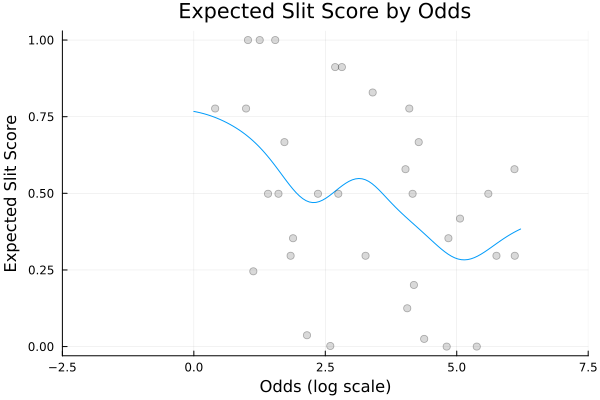

In [8]:
using Statistics
using Plots

# 特定のoddsにおけるslit_scoreの条件付き期待値を計算する関数
function conditional_mean(odds_point, df, bandwidth=0.5)
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    return sum(weights .* df.slit_score) / sum(weights)
end

# オッズの範囲でグリッドを作成
odds_grid = exp.(range(log(1.0), log(500), length=100))

# 各オッズポイントでの条件付き期待値を計算
mean_slit_scores = [conditional_mean(o, df) for o in odds_grid]

p = plot(log.(odds_grid), mean_slit_scores, 
    xlabel="Odds (log scale)", 
    ylabel="Expected Slit Score",
    xlim=(-2.5, 7.5),
    legend=false,
    title="Expected Slit Score by Odds")

# 実データ点も同じスケールで表示
scatter!(log.(df.odds), df.slit_score, alpha=0.3, color=:gray)

# x軸のティックを実数表示に変更
xticks!(-2.5:2.5:7.5)  # 等高線グラフと同じ実数表示

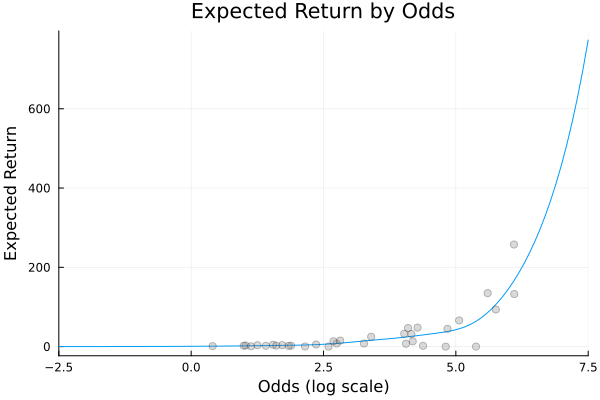

In [15]:
# 期待収益（Expected Return）を計算する関数
function expected_return(odds_point, df, bandwidth=0.5)
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    expected_slit = sum(weights .* df.slit_score) / sum(weights)
    return expected_slit * odds_point  # オッズを実数値で掛け算
end

# オッズの範囲でグリッドを作成（実数値）
odds_grid = exp.(range(-2.5, 7.5, length=100))

# 各オッズポイントでの期待収益を計算
expected_returns = [expected_return(o, df) for o in odds_grid]

# プロット
p = plot(log.(odds_grid), expected_returns, 
    xlabel="Odds (log scale)", 
    ylabel="Expected Return",
    xlim=(-2.5, 7.5),
    legend=false,
    title="Expected Return by Odds")

# 実データ点も表示（各馬の実際の期待収益）
scatter!(log.(df.odds), df.slit_score .* df.odds, alpha=0.3, color=:gray)

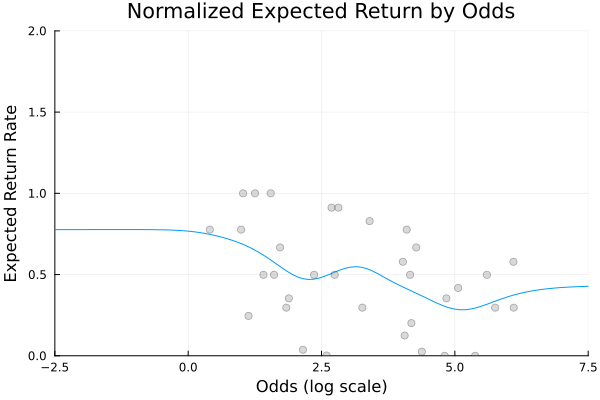

In [16]:
# 期待収益を正規化する関数
function normalized_expected_return(odds_point, df, bandwidth=0.5)
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    expected_slit = sum(weights .* df.slit_score) / sum(weights)
    
    # 期待収益を1に正規化（収益率として表現）
    return (expected_slit * odds_point) / odds_point
end

# プロット更新
p = plot(log.(odds_grid), [normalized_expected_return(o, df) for o in odds_grid], 
    xlabel="Odds (log scale)", 
    ylabel="Expected Return Rate",  # 収益率として表示
    xlim=(-2.5, 7.5),
    ylim=(0, 2),  # 適切な範囲に制限
    legend=false,
    title="Normalized Expected Return by Odds")

# 実データ点も正規化して表示
scatter!(log.(df.odds), df.slit_score, alpha=0.3, color=:gray)